#**Building a Gen AI RAG Chatbot from Scratch**

---




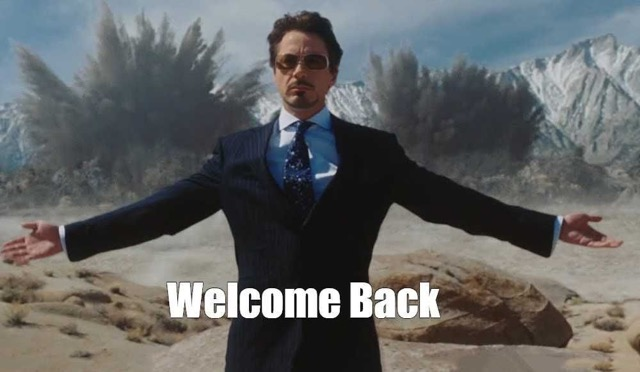

## Day 1 Recap:

Yesterday, we learned the basics of creating a chatbot. Here's a quick reminder of what we covered:
- We talked about **AI chatbots** and how tools like **ChatGPT** work, and **open source models work**
- We learned about **LangChain**, which helps connect AI models to our chatbot.
- We used **Groq** to power our chatbot by connecting it to an open-source AI model called **Llama**.

Today, we will build on this by adding some new features to our chatbot—like having it search from documents and retrieve information.


##**<font color='Navy-Blue'>Day 2: Langchain, PDF Parser, Chunks, Tokenizer, ChromaDB and Meta Llama</font>**

Today, we are going to make our chatbot smarter by teaching it how to look through **documents** and give us relevant answers. This is where **ChromaDB** comes into play. Let’s break down the code step by step.



### Key Concepts for Today:
1. **Embeddings**: Embeddings are like number versions of text that capture its meaning. Instead of just looking at words separately, embeddings turn text into a series of numbers (called vectors), which helps the model figure out how similar two texts are.<br><br>
Basically, if two pieces of text mean the same thing, their vectors will be close together. If they're really different, the vectors will be far apart.
<br><br>

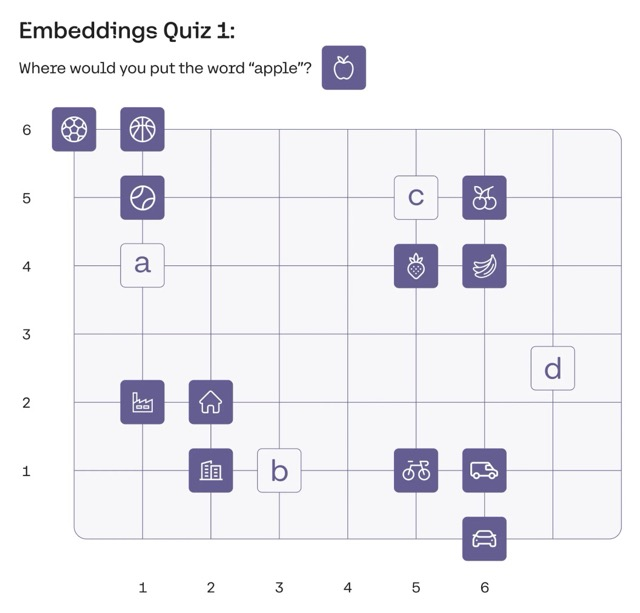


So apple would go near point C as they are fruits

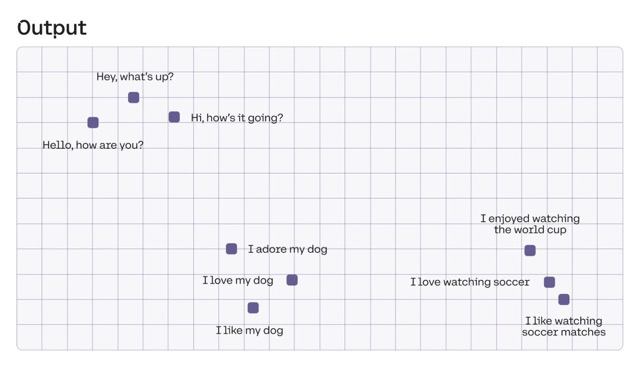

This what sentence embeddings would look like, if we had plotted them in a vector graph


2. **Vector Store**: A special database that stores these embeddings, allowing the chatbot to quickly search for the most relevant text when you ask a question.

## What is ChromaDB?
In simple terms, **ChromaDB** is a tool that allows our chatbot to store and search through **text data**. It creates something called a **vector store**, which is like a database that helps the chatbot understand and find pieces of text based on their meaning.






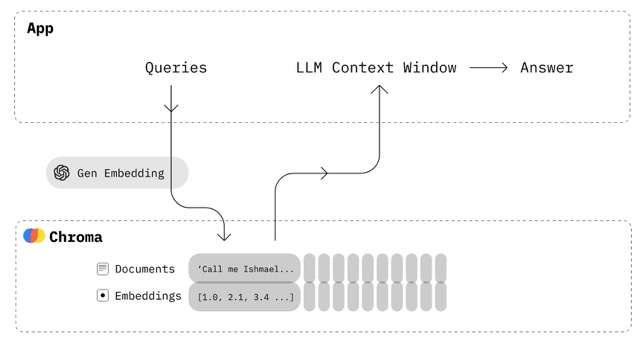

In the above architecture, we store, retireve embeddings from chromadb for our queries

# BIGGER question now how do we generate these embeddings?????

# Now comes in Hugging Face, so how does hugging face solve our problem??

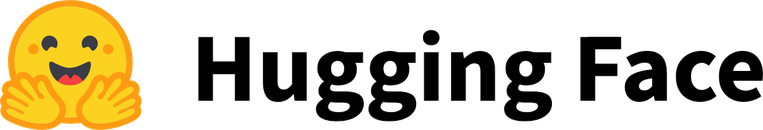

## What are HuggingFaceEmbeddings?
A set of pre-trained models provided by Hugging Face, a popular platform in the machine learning community, a variety of models, such as BERT, GPT, and RoBERTa, which can generate embeddings for different NLP tasks.

#**So Lets start**<br>
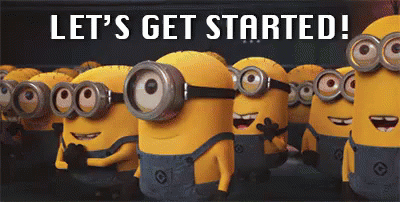

**Step 1: Install the necessary libraries**

In [1]:
!pip install langchain langchain_community sentence_transformers chromadb pypdf langchain-groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Step 2: Import all the libraries**

In [2]:
#importing required libraries

import os
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

**Step 3: Set up Groq API key and load the documents**<br>


In [3]:
# Set your Groq API key
os.environ["GROQ_API_KEY"] = ""
#loading the document
PERSIST_DIRECTORY = "/content/chroma_db"
folder_path = r"/content/aml"
DOCUMENT_PATH = r"/content/aml/2307.pdf"

**Step 4: Vector Store**<br>
Here, we’re checking if the vector store already exists. If it does, we load it. If not, we create a new one by turning our documents into embeddings and saving them in ChromaDB.

In [4]:
def load_or_create_vector_store(texts, embeddings):
    # Check if the vector store already exists
    if os.path.exists(PERSIST_DIRECTORY):
        print("Loading existing vector store...")
        return Chroma(persist_directory=PERSIST_DIRECTORY, embedding_function=embeddings)

    # If not, create a new one
    print("Creating new vector store...")
    return Chroma.from_documents(texts, embeddings, persist_directory=PERSIST_DIRECTORY)

**Step 5: Load and Split Documents**<br>
We’re loading a document (Research paper) and splitting it into smaller chunks, making it easier for the chatbot to search and understand.

PDFloader: Reads the pdf document.
TextSplitter: Splits long texts into smaller parts, so the chatbot can work with manageable chunks.

In [5]:
# Load and preprocess documents
def load_documents(document_path):
    all_texts = []  # To store the texts from all PDFs
    # Iterate over each file in the folder
    for filename in os.listdir(folder_path):
        # Only process files that end with .pdf
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            loader = PyPDFLoader(file_path)  # Load the individual PDF
            documents = loader.load()  # Load documents from the PDF

            # Split the loaded documents into smaller chunks
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len,
                separators=["\n\n", "\n", " ", ""]
            )
            texts = text_splitter.split_documents(documents)
            all_texts.extend(texts)
    return all_texts

**Step 6: Create Vector Embeddings**<br>
This section creates embeddings for each chunk of text and stores them in ChromaDB. Now our chatbot can “understand” and “search” the documents based on their meaning, not just by keywords.



In [6]:
texts = load_documents(folder_path)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/msmarco-distilbert-base-v4")
db = Chroma.from_documents(texts, embeddings)
# db.add_documents(texts)
db.persist()

<ipython-input-6-07f8b78a1717>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/msmarco-distilbert-base-v4")
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/319 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-6-07f8b78a1717>:5: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


**Step 7: Set Up the Chat Model**<br>This is the same as yesterday—setting up our Llama model to respond to user input.

In [7]:
# Set up the language model
llm = ChatGroq(model="llama-3.2-3b-preview") # Choose an appropriate open-source model

**Step 8: Creating a Prompt Template**<br>
We’re telling the chatbot how to respond when asked a question. It uses the context from the documents to give an answer.



In [8]:
# Create a custom prompt template. You can give instructions to the model. This Defines a prompt template for a RAG model to format context and question for answer generation.

template = """Use the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer: """
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"], template=template)




**Step 9: RAG Pipeline**<br>
This is where we connect the chatbot to the document retrieval system. The chatbot can now retrieve information from the documents using ChromaDB and respond with relevant answers.



In [9]:
# Set up the RAG pipeline
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [10]:
# Chatbot interface. Chnage it on your own preference
print("Welcome to the RAG Chatbot! Type 'exit' to end the conversation.")
while True:
    user_input = input("You: ")
    if user_input.lower() == 'exit':
        print("Goodbye!")
        break

    response = qa_chain.invoke({"query": user_input})

    print("Chatbot:", response['result'])

Welcome to the RAG Chatbot! Type 'exit' to end the conversation.
You: summarize the auto grader project
Chatbot: The Auto Grader project is a research initiative focused on developing an advanced system for retrieving and analyzing student assignments. The primary objective is to create a comprehensive technology stack that can effectively assess student submissions, retrieve relevant assignments, compare responses to correct solutions, analyze code quality, and dynamically grade submissions.

The project involves several key components, including:

1. Building a Retriever: This involves structuring student assignments in a standardized format and implementing a retrieval system using LangChain for semantic search capabilities.
2. Data Structuring: Student assignments are stored in a Chroma DB with metadata, questions, and answers.
3. Dynamic Grading: The system will utilize advanced technology to dynamically grade submissions.

While the main focus of the project is on developing a ro

Today we learned how to implement the embeddings, store them in a vector store and then use those same embeddings to retrieve embeddings related to our query.
Then pass the same to a LLM for answering our query based on that data

This whole process is what we know as RAG-Retireval Augemnted Generation

#**And thats it for Day 2**
We'll see you tommorow here at same place, on same time